# Setup

In [ ]:
!pip install diffusers==0.18.2

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Training Configuration

In [ ]:
from dataclasses import dataclass


@dataclass
class TrainingConfig:
    sequence_length = 256  # the generated image resolution
    train_data_paths = ['/content/p8_111.csv']
    filter_class = 2 # relax: 0, open: 1, and close: 2
    channel_shuffle = False
    emgs_cnt = 8 # must be 8 for 2D UNet
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 200
    save_epochs = 50
    learning_rate = 4e-4

    noise_scheduler_timesteps = 500

    # these three should be deleted
    noise_type = "normal" # normal
    noise_mean = 0
    noise_std = 1 # if using huggingface pipeline, set it to 1

    gen_batch_size = 9 # gen_batch_size = nrows * ncols
    nrows = 3
    ncols = 3

    model_type = "2DUNet"

    load_model = True
    load_model_path = "./2Dunet-p8-111-close2-ep400"
    train = False
    save_model = False
    save_model_path = "./2Dunet-p8-111-close2-ep200"


config = TrainingConfig()

# Visualization Helper functions

In [ ]:
import matplotlib.pyplot as plt

def visualize_one_emg(data, emg_idx):
  plt.plot(data)
  plt.xlabel('Time')
  plt.ylabel('emg '+str(emg_idx)+' normalized value')
  plt.show()
  plt.close()

def visualize_sample(sample, emgs_cnt, unsqueeze=True):
  if unsqueeze:
    sample = sample.unsqueeze(0)
  print(sample.shape)
  for i in range(emgs_cnt):
    visualize_one_emg(sample[0][i], i)
    pass

From misc_utils

In [ ]:
def plot_emg_chunks(data, nrows=1, ncols=1, vertical_location=None):
    """
    data: (b, t, 8), b = nrows * ncols
    """
    # missing the batch dimension
    if np.ndim(data) == 2:
        data = data[None, ...]
    b, t = data.shape[:2]
    fig, axs = plt.subplots(figsize=(15, 9), nrows=nrows, ncols=ncols, squeeze=False)

    idx = np.array(range(t)) / 100.0
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:brown']

    for i in range(nrows):
        for j in range(ncols):
            for c in range(8):
                y = data[i*ncols+j, :, c]
                axs[i, j].plot(idx, y, label=f'emg{c}', alpha=0.7, color=colors[c])
                if vertical_location is not None:
                    axs[i, j].axvline(x=vertical_location / 100.0, c='b')
                if i*ncols+j == b - 1:
                    axs[i, j].legend()

    plt.xlabel('time (seconds)')
    plt.tight_layout()

    plt.show()

#ChatEMG Dataset

Statistics of p1_111:<br>
Mean of each emg: <br>[0.0451946  0.14492683 0.19912494 0.08450989 0.08813588 0.05372675
 0.04034895 0.07792921] <br>
Std of each emg: <br>
[0.02988127 0.06865422 0.11946873 0.07062819 0.07399311 0.08520439
 0.02091565 0.04998798]

From misc_utils.py

In [ ]:
# copied from misc_utils.py from emg_predictors
def keep_columns(df, tuple_of_columns):
    """
    Given a dataframe, and a tuple of column names, this function will search
    through the dataframe and keep only columns which contain a string from the
    list of the desired columns. All other columns are removed
    """
    if len(tuple_of_columns) >= 1:
        cols = df.columns[df.columns.to_series().str.contains('|'.join(tuple_of_columns))]
        return df[cols]
    return df

def clean_dataframe(df):
    X_df = keep_columns(df, [f'emg'])
    X = X_df.to_numpy()
    y_df = keep_columns(df, ['gt'])
    y = y_df.to_numpy().squeeze()
    return X, y

From ChatEMG Dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader
import os
import pathlib
#import misc_utils as mu
import pandas as pd
import numpy as np


class ChatEMGDataset(Dataset):
    def __init__(self, csv_files, filter_class, block_size, normalize=False):
        self.csv_files = csv_files
        self.filter_class = filter_class
        self.block_size = block_size

        #self.data_files_base_directory = \os.path.join(pathlib.Path(__file__).resolve().parent.parent.__str__(), 'collected_data')

        data_list = []
        label_list = []
        for f in self.csv_files:
            #data_path = os.path.join(self.data_files_base_directory, f)
            data_path = f
            df = pd.read_csv(data_path, index_col=0)
            #X, y = mu.clean_dataframe(df)
            X, y = clean_dataframe(df)
            X = np.clip(X, a_min=0, a_max=999)
            X = X / 999 if normalize else X
            data_list.append(X)
            label_list.append(y)

        self.filtered_data_list = data_list
        if self.filter_class is not None:
            self.filtered_data_list = []
            for d, l in zip(data_list, label_list):
                filtered_d = []
                for i in range(len(d)):
                    if l[i] == self.filter_class:
                        filtered_d.append(d[i])
                        if i+1 == len(d) or l[i+1] != self.filter_class:
                            self.filtered_data_list.append(np.array(filtered_d))
                            filtered_d = []

        # now I am removing chunks shorter than block size + 1, because we need to consider y as well
        self.filtered_data_list = [d for d in self.filtered_data_list if len(d) >= (self.block_size + 1)]
        # number of (x, y) pairs in each chunk
        self.filtered_data_lens = [len(d) - self.block_size for d in self.filtered_data_list]

    def __len__(self):
        return sum(self.filtered_data_lens)

    def __getitem__(self, item):
        assert item < self.__len__()

        s = 0
        for i, l in enumerate(self.filtered_data_lens):
            s_new = s + l
            if s <= item < s_new:
                x = self.filtered_data_list[i][item - s: item - s + self.block_size]
                # print(item - s, item - s + self.block_size)
                y = self.filtered_data_list[i][item - s + 1: item - s + self.block_size + 1]
                # print(item - s + 1, item - s + self.block_size + 1)
                # print(i)
                return x, y
            s = s_new

    def sample(self, num):
        # sample some samples without replacement
        idx = np.random.choice(range(self.__len__()), num, replace=False)
        X = []
        Y = []
        for i in idx:
            x, y = self.__getitem__(i)
            X.append(x)
            Y.append(y)
        return np.stack(X), np.stack(Y)

In [ ]:
from torch.utils.data import Dataset, DataLoader
import os
import pathlib
#import misc_utils as mu
import pandas as pd
import numpy as np


class ChatEMGDataset(Dataset):
    def __init__(self, csv_files, filter_class, block_size, normalize=False, standardize=False, shuffle_channel=False):
        assert not (normalize and standardize)  # cannot standardize and normalize at the same time
        self.csv_files = csv_files
        self.filter_class = filter_class
        self.block_size = block_size
        self.shuffle_channel = shuffle_channel
        self.normalize = normalize
        self.standardize = standardize

        #self.data_files_base_directory = \os.path.join(pathlib.Path(__file__).resolve().parent.parent.__str__(), 'collected_data')

        data_list = []
        label_list = []
        for f in self.csv_files:
            #data_path = os.path.join(self.data_files_base_directory, f)
            data_path = f
            df = pd.read_csv(data_path, index_col=0)
            #X, y = mu.clean_dataframe(df)
            X, y = clean_dataframe(df)
            if normalize:
                X = np.clip(X, a_min=0, a_max=999)
                X = X / 999
            data_list.append(X)
            label_list.append(y)

        self.filtered_data_list = data_list
        if self.filter_class is not None:
            self.filtered_data_list = []
            for d, l in zip(data_list, label_list):
                filtered_d = []
                for i in range(len(d)):
                    if l[i] == self.filter_class:
                        filtered_d.append(d[i])
                        if i+1 == len(d) or l[i+1] != self.filter_class:
                            self.filtered_data_list.append(np.array(filtered_d))
                            filtered_d = []

        # now I am removing chunks shorter than block size + 1, because we need to consider y as well
        self.filtered_data_list = [d for d in self.filtered_data_list if len(d) >= (self.block_size + 1)]
        # compute mean and std
        self.mean = np.mean(np.concatenate(self.filtered_data_list), axis=0)
        self.std = np.std(np.concatenate(self.filtered_data_list), axis=0)
        if self.standardize:
            self.filtered_data_list = [(d - self.mean) / self.std for d in self.filtered_data_list]
        # number of (x, y) pairs in each chunk
        self.filtered_data_lens = [len(d) - self.block_size for d in self.filtered_data_list]

    def overwrite_mean_std(self, mean, std):
        assert self.standardize
        # revert the standardization process
        self.filtered_data_list = [d * self.std + self.mean for d in self.filtered_data_list]
        self.mean = mean
        self.std = std
        # standardization using the new mean and std
        self.filtered_data_list = [(d - self.mean) / self.std for d in self.filtered_data_list]

    def __len__(self):
        return sum(self.filtered_data_lens)

    def __getitem__(self, item):
        assert item < self.__len__()

        s = 0
        for i, l in enumerate(self.filtered_data_lens):
            s_new = s + l
            if s <= item < s_new:
                x = self.filtered_data_list[i][item - s: item - s + self.block_size]
                # print(item - s, item - s + self.block_size)
                y = self.filtered_data_list[i][item - s + 1: item - s + self.block_size + 1]
                # print(item - s + 1, item - s + self.block_size + 1)
                # print(i)
                if self.shuffle_channel:
                    permutation = np.random.permutation(8)
                    x = x[:, permutation]
                    y = y[:, permutation]
                return x, y
            s = s_new

    def sample(self, num):
        # sample some samples without replacement
        idx = np.random.choice(range(self.__len__()), num, replace=False)
        X = []
        Y = []
        for i in idx:
            x, y = self.__getitem__(i)
            X.append(x)
            Y.append(y)
        return np.stack(X), np.stack(Y)

In [ ]:
dataset = ChatEMGDataset(
    csv_files = config.train_data_paths,
    filter_class = config.filter_class,
    block_size = config.sequence_length,
    normalize = True,
    shuffle_channel = config.channel_shuffle
)
print("sum samples: ", len(dataset))

sum samples:  849


Support function: get_sample, will convert to our shape

In [ ]:
def get_sample(cnt):
  raw_sample = dataset.sample(cnt)
  # convert to np array
  np_sample = np.array(raw_sample) # (2, cnt, block_size, emg_cnt)
  # take only the X component
  x_sample = np_sample[0] # (cnt, block_size, emg_cnt)
  # permute the dimensions
  trans_sample = np.transpose(x_sample, axes=(0,2,1)) #(cnt, emg_cnt, block_size)
  # convert to torch
  sample_tensor = torch.tensor(trans_sample).to(torch.float32)
  return sample_tensor

In [ ]:
import torch

#train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=config.train_batch_size, shuffle=True)
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

In [ ]:
sample_seqs = np.array(dataset.sample(9))
sample_seqs = sample_seqs[0]
print(sample_seqs.shape)
plot_emg_chunks(sample_seqs, nrows=3, ncols=3)

# Load an Existing UNet2D Model

In [ ]:
!unzip 2Dunet-p8-111-close2-ep200.zip

Archive:  2Dunet-p8-111-close2-ep200.zip
replace content/2Dunet-p8-111-close2-ep200/diffusion_pytorch_model.bin? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: content/2Dunet-p8-111-close2-ep200/diffusion_pytorch_model.bin  
  inflating: content/2Dunet-p8-111-close2-ep200/config.json  


In [ ]:
from diffusers import UNet2DModel
if config.load_model and config.model_type=="2DUNet":
  model = UNet2DModel.from_pretrained(config.load_model_path).to(device)

In [ ]:
model = UNet2DModel.from_pretrained('/content/content/2Dunet-p8-111-close2-ep200').to(device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


# Create a UNet2DModel

In [ ]:
from diffusers import UNet2DModel

# Create a model
if not config.load_model:
  model = UNet2DModel(
      sample_size=(config.emgs_cnt,config.sequence_length),  # the target image resolution
      in_channels=1,  # the number of input channels, 3 for RGB images
      out_channels=1,  # the number of output channels
      layers_per_block=2,  # how many ResNet layers to use per UNet block
      block_out_channels=(64, 128, 128, 256),  # More channels -> more parameters
      down_block_types=(
          "DownBlock2D",  # a regular ResNet downsampling block
          "DownBlock2D",
          "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
          "AttnDownBlock2D",
      ),
      up_block_types=(
          "AttnUpBlock2D",
          "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
          "UpBlock2D",
          "UpBlock2D",  # a regular ResNet upsampling block
      ),
  )
  model.to(device);

use pretrained checkpoints

check the input shape and output shape

In [ ]:
sample_seq = get_sample(1)
print(sample_seq.shape)
sample_for_plot = sample_seq.permute(0,2,1)
plot_emg_chunks(sample_for_plot)
sample_seq = sample_seq.to(device)

if config.model_type=="2DUNet":
  sample_seq = sample_seq.unsqueeze(1)
print("Input shape:", sample_seq.shape)

Expect format: (batch, channel, height, width).

In [ ]:
print("Output shape:", model(sample_seq, timestep=0).sample.shape)

Output shape: torch.Size([1, 1, 8, 256])


Check the number of parameters

In [ ]:
sum([p.numel() for p in model.parameters()])

18534017

# Create a Scheduler

Create a noise scheduler & plot its scheduling curve

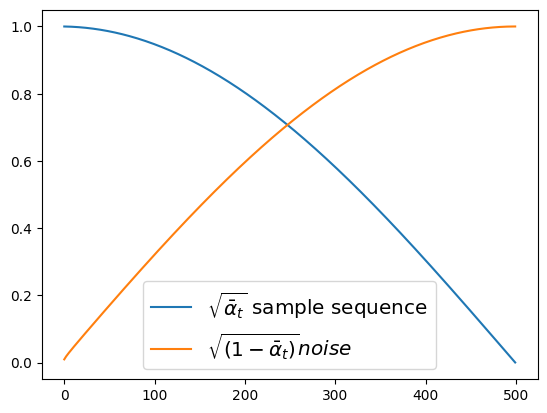

In [ ]:
from diffusers import DDPMScheduler

# Scheduler: can change parameters such as beta_start=0.001, beta_end=0.004, beta_schedule='squaredcos_cap_v2'
noise_scheduler = DDPMScheduler(num_train_timesteps=config.noise_scheduler_timesteps, beta_schedule='squaredcos_cap_v2')

# plot
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$ sample sequence")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)} noise$")
plt.legend(fontsize="x-large");

Testing add noise

Problem: each sequential segments has very diverse distribution: compare traindata[1000] with traindata[5300]</br>
for sample_idx == 1000, normal noise will corrupt too soon, uniform noise will be better </br>
for sample_idx == 5300, uniform noise not enough, normal noise good

In [ ]:
view_cnt = 1
noise_type = config.noise_type# normal: normal distribution; uniform: uniform distribution within {-1,1}

sample_seq = get_sample(1)
print("Original Sequence from sample: ")
print("mean: ", np.mean(sample_seq.numpy(), axis=2))
visualize_sample(sample_seq[0], view_cnt)

noise = torch.randn(sample_seq.shape) # original can i bound its range # reduce the range

# print("Noise added:")
# print("Noise max", np.max(noise.numpy()))
# print("Noise min", np.min(noise.numpy()))
# print("Noise shape", noise.numpy().shape)
# print("Noise mean", np.mean(noise.numpy(), axis=2))
# print("Noise std", np.std(noise.numpy(), axis=2))
print(noise.shape)
visualize_sample(noise[0], view_cnt)

for steps_added in [0, 100, 200, 300, 400, 499]:
  print("steps_added: ", steps_added)
  timesteps = torch.LongTensor([steps_added])
  noisy_seq = noise_scheduler.add_noise(sample_seq, noise, timesteps)
  print("mean: ", np.mean(noisy_seq.numpy(), axis=2))
  print("Sequence + Noise:")
  visualize_sample(noisy_seq[0], view_cnt)

# Create a Train Loop

from train.py

In [ ]:
def get_batch(split):
    if split == 'train':
        return next(iter(train_dataloader))
    elif split == 'val':
        return next(iter(test_dataloader))

my support function

In [ ]:
def diffuser_batch_preprocess(X, is2d=False):
  trans_X = np.transpose(X, axes=(0,2,1))
  tensor_X = torch.tensor(trans_X).to(torch.float32)
  if is2d:
    tensor_X = tensor_X.unsqueeze(1)
    # expected shape: (batch, channel, height, width),
    # here we are setting it to (batch, 1, height=8=emgChannels, width=sequence_length)
  return tensor_X

check generate seqs

In [ ]:
from diffusers import DDPMPipeline

def deterministic_generate_sequences(this_model):
  deterministic_generator = torch.Generator()
  deterministic_generator.manual_seed(42)
  emgseq_pipe = DDPMPipeline(unet=this_model, scheduler=noise_scheduler)
  pipeline_output = emgseq_pipe(batch_size=config.gen_batch_size,num_inference_steps=config.noise_scheduler_timesteps,output_type=np.array,generator=deterministic_generator)
  gen_seqs = pipeline_output.images
  gen_seqs = gen_seqs.squeeze()
  print("shape: ", gen_seqs.shape)
  gen_seqs = np.transpose(gen_seqs, axes=(0,2,1))
  print("mean: ", np.mean(gen_seqs, axis=2))
  print("std: ", np.std(gen_seqs, axis=2))
  plot_emg_chunks(gen_seqs, nrows=config.nrows, ncols=config.ncols)
  return pipeline_output.images

In [ ]:
import torch.nn.functional as F

if config.train:
  # Set the noise scheduler
  noise_scheduler = DDPMScheduler(
      num_train_timesteps=config.noise_scheduler_timesteps, beta_schedule="squaredcos_cap_v2"
  )

  # Training loop
  optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

  losses = []

  print("Total epochs: ",  config.num_epochs)
  for epoch in range(config.num_epochs):
      print("Epoch: ", epoch)
      for step, batch in enumerate(train_dataloader):
        batch_x, batch_y = get_batch('train')
        batch = diffuser_batch_preprocess(batch_x, is2d=True)
        clean_seqs = batch.to(device)
          #print("batch shape: ", batch.shape)

          # Sample noise to add to the images
        noise = torch.randn(clean_seqs.shape).to(device)

        bs = clean_seqs.shape[0] #batch size

          # Sample a random timestep for each image
        timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=device).long()

          # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_seqs = noise_scheduler.add_noise(clean_seqs, noise, timesteps)

          # Get the model prediction
        noise_pred = model(noisy_seqs, timesteps, return_dict=False)[0]

          # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

          # Update the model parameters with the optimizer
          # why UNet side no gradient
        optimizer.step()
        optimizer.zero_grad()

      if (epoch + 1) % 5 == 0:
          loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
          print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")
      # saving
      if (epoch + 1) % config.save_epochs == 0:
        print("Saving...")
        save_path = "./2DUnet-p8-train-ep"+str(epoch+1)
        model.save_pretrained(save_path)
        output = deterministic_generate_sequences(model)

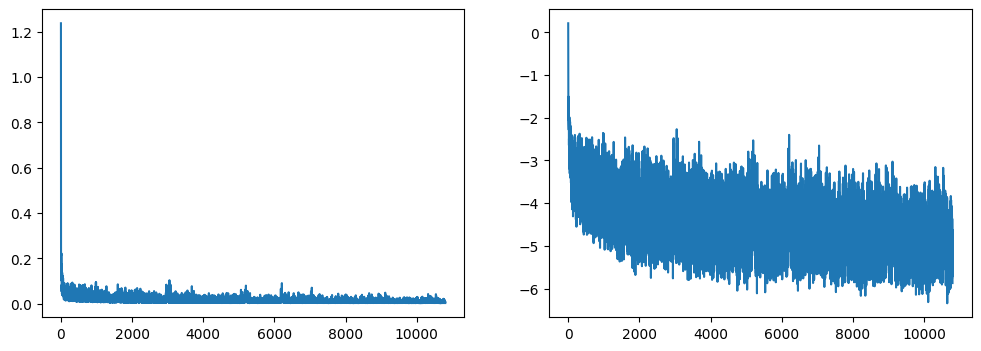

In [ ]:
if config.train:
  fig, axs = plt.subplots(1, 2, figsize=(12, 4))
  axs[0].plot(losses)
  axs[1].plot(np.log(losses))
  plt.show()

# Save model

In [ ]:
if config.save_model:
  model.save_pretrained(config.save_model_path)

# Generate Sequence

In [ ]:
from diffusers import DDPMPipeline

emgseq_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

In [ ]:
def generate_sequences():
  pipeline_output = emgseq_pipe(batch_size=config.gen_batch_size,num_inference_steps=config.noise_scheduler_timesteps,output_type=np.array)
  gen_seqs = pipeline_output.images
  gen_seqs = gen_seqs.squeeze()
  print("shape: ", gen_seqs.shape)
  gen_seqs = np.transpose(gen_seqs, axes=(0,2,1))
  print("final shape: ", gen_seqs.shape)
  print("mean: ", np.mean(gen_seqs, axis=2))
  print("std: ", np.std(gen_seqs, axis=2))
  plot_emg_chunks(gen_seqs, nrows=config.nrows, ncols=config.ncols)
  return gen_seqs

In [ ]:
def transform_to_real_value(data):
  return data*1000

In [ ]:
def transform_similar_normalize(model_output): #(256, 8)
  loader = torch.utils.data.DataLoader(dataset, shuffle=False, num_workers=0, batch_size=1)
  best_loss = 100000
  best_exist = None
  best_normalized = None
  best_id = None
  best_mean = None
  best_std = None
  model_output_mean = np.mean(model_output, axis = 0)
  model_output_std = np.std(model_output, axis = 0)
  model_output = (model_output - model_output_mean) / model_output_std
  #print("Normalized Model Output:")
  #plot_emg_chunks(model_output, ncols=1, nrows=1)
  for id, (exist_seq, y) in enumerate(loader): # exist_seq is of shape (1, 256, 8)
    exist_seq = exist_seq.squeeze()
    exist_seq = np.array(exist_seq)
    #print("exist_seq shape: ", np.array(exist_seq).shape) #(256,8)
    # Calculate mean and standard deviation along each channel
    ex_mean = np.mean(exist_seq, axis=0)
    ex_std = np.std(exist_seq, axis=0)
    # Normalize each channel
    normalized_exist_seq = (exist_seq - ex_mean) / ex_std
    mse = mean_squared_error(model_output, normalized_exist_seq)
    #print("mse: ", mse)
    if mse < best_loss:
      best_loss = mse
      best_exist = exist_seq
      best_normalized = normalized_exist_seq
      best_id = id
      best_mean = ex_mean
      best_std = ex_std

  print("Best existing: ")
  plot_emg_chunks(best_exist, nrows=1, ncols=1)
  model_output = model_output*best_std + best_mean
  #print("Transformed Model Output: ")
  #plot_emg_chunks(model_output, nrows=1, ncols=1)
  return model_output

In [ ]:
output = generate_sequences() #(9, 256, 8)

transform by 1000

In [ ]:
import numpy as np
import csv

reshaped_array = output.transpose(2, 1, 0).reshape(8, -1)

# from [0,1] value to real EMG value
reshaped_array = transform_to_real_value(reshaped_array)

# Create column names
column_names = ['emg0', 'emg1', 'emg2', 'emg3', 'emg4', 'emg5', 'emg6', 'emg7', 'gt']

# Add 'gt' column with all
gt_column = [str(config.filter_class)]*reshaped_array.shape[1]


# Concatenate 'gt' column to the reshaped array
final_array = np.vstack((reshaped_array, gt_column))

# Transpose the final array for correct column orientation
final_array = final_array.T

# CSV file name
csv_file = 'data.csv'

# Save the array to CSV
# with open(csv_file, mode='w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(column_names)  # Write column names as the first row
#     writer.writerows(final_array)

# transform by first finding the most similar existing sequence, then reverse normalize with the existing sequence's mean and std

In [ ]:
import numpy as np
import csv
from sklearn.metrics import mean_squared_error

transformed_seqs = []

for i in range(output.shape[0]):
  this_seq = output[i]
  print("Before Transformation")
  plot_emg_chunks(this_seq, nrows=1, ncols=1)
  this_seq = transform_similar_normalize(this_seq)
  print("After Transformation")
  plot_emg_chunks(this_seq, nrows=1, ncols=1)
  # need to times 1000
  transformed_seqs.append(this_seq*1000)


In [ ]:
print(transformed_seqs[0].shape)

(256, 8)


In [ ]:
for i in range(len(transformed_seqs)):
  transformed_seqs[i] = transformed_seqs[i].transpose(1, 0)

In [ ]:
stacked = np.concatenate(transformed_seqs, axis=1)
print(stacked.shape)

(8, 2304)


In [ ]:

# Create column names
column_names = ['emg0', 'emg1', 'emg2', 'emg3', 'emg4', 'emg5', 'emg6', 'emg7', 'gt']

# Add 'gt' column with all
gt_column = [str(config.filter_class)]*stacked.shape[1]


# Concatenate 'gt' column to the reshaped array
final_array = np.vstack((stacked, gt_column))

# Transpose the final array for correct column orientation
final_array = final_array.T

# CSV file name
csv_file = 'data.csv'

#Save the array to CSV
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(column_names)  # Write column names as the first row
    writer.writerows(final_array)

# For Comparison

In [ ]:
from diffusers import DDPMPipeline

def deterministic_generate_sequences(this_model):
  deterministic_generator = torch.Generator()
  deterministic_generator.manual_seed(42)
  emgseq_pipe = DDPMPipeline(unet=this_model, scheduler=noise_scheduler)
  pipeline_output = emgseq_pipe(batch_size=config.gen_batch_size,num_inference_steps=config.noise_scheduler_timesteps,output_type=np.array,generator=deterministic_generator)
  gen_seqs = pipeline_output.images
  gen_seqs = gen_seqs.squeeze()
  print("shape: ", gen_seqs.shape)
  gen_seqs = np.transpose(gen_seqs, axes=(0,2,1))
  print("mean: ", np.mean(gen_seqs, axis=2))
  print("std: ", np.std(gen_seqs, axis=2))
  plot_emg_chunks(gen_seqs, nrows=config.nrows, ncols=config.ncols)
  return pipeline_output.images

In [ ]:
output = deterministic_generate_sequences(model)


#Find the closest sample in Dataset

Given a model output, find the existing data in ChatEMGDataset that has similar shape. This is intend to check if the model output is just duplicate of existing data

In [ ]:
from sklearn.metrics import mean_squared_error

def find_similar(model_output, dataset):
  print("model_output shape: ", model_output.shape) #(256,8) after squeeze and transpose
  loader = torch.utils.data.DataLoader(dataset, shuffle=False, num_workers=0, batch_size=1)
  best_loss = 100000
  best_exist = None
  best_id = None
  for id, (exist_seq, y) in enumerate(loader): # exist_seq is of shape (1, 256, 8)
    exist_seq = exist_seq.squeeze()
    #print("exist_seq shape: ", np.array(exist_seq).shape) #(256,8)
    mse = mean_squared_error(model_output, exist_seq)
    #print("mse: ", mse)
    if mse < best_loss:
      best_loss = mse
      best_exist = exist_seq
      best_id = id
  return best_loss, best_exist, best_id

In [ ]:
def find_similar_2(model_output, dataset):
  print("model_output shape: ", model_output.shape) #(256,8) after squeeze and transpose
  loader = torch.utils.data.DataLoader(dataset, shuffle=False, num_workers=0, batch_size=1)
  best_loss = 100000
  best_exist = None
  best_id = None
  for id, (exist_seq, y) in enumerate(loader): # exist_seq is of shape (1, 256, 8)
    exist_seq = exist_seq.squeeze()
    #print("exist_seq shape: ", np.array(exist_seq).shape) #(256,8)
    model_output = model_output - 0.5
    model_output = model_output*2
    model_output[model_output < 0] = 0
    model_output[model_output > 1] = 1
    mse = mean_squared_error(model_output, exist_seq)
    #print("mse: ", mse)
    if mse < best_loss:
      best_loss = mse
      best_exist = exist_seq
      best_id = id
  return best_loss, best_exist, best_id

In [ ]:
def find_similar_3(model_output, dataset):
  print("model_output shape: ", model_output.shape) #(256,8) after squeeze and transpose
  loader = torch.utils.data.DataLoader(dataset, shuffle=False, num_workers=0, batch_size=1)
  best_loss = 100000
  best_exist = None
  best_normalized = None
  best_id = None
  model_output_mean = np.mean(model_output, axis = 0)
  model_output_std = np.std(model_output, axis = 0)
  model_output = (model_output - model_output_mean) / model_output_std
  print("Normalized Model Output:")
  plot_emg_chunks(model_output, ncols=1, nrows=1)
  for id, (exist_seq, y) in enumerate(loader): # exist_seq is of shape (1, 256, 8)
    exist_seq = exist_seq.squeeze()
    exist_seq = np.array(exist_seq)
    #print("exist_seq shape: ", np.array(exist_seq).shape) #(256,8)
    # Calculate mean and standard deviation along each channel
    ex_mean = np.mean(exist_seq, axis=0)
    ex_std = np.std(exist_seq, axis=0)
    # Normalize each channel
    normalized_exist_seq = (exist_seq - ex_mean) / ex_std
    mse = mean_squared_error(model_output, normalized_exist_seq)
    #print("mse: ", mse)
    if mse < best_loss:
      best_loss = mse
      best_exist = exist_seq
      best_normalized = normalized_exist_seq
      best_id = id
  return best_loss, best_exist, best_normalized, best_id

In [ ]:
images = deterministic_generate_sequences(model)

In [ ]:
model_output = images[1]

In [ ]:
model_output = model_output.squeeze()
print(model_output.shape) #(8,256)

model_output = np.transpose(model_output, axes=(1,0))
print(model_output.shape) #(256,8)


(8, 256)
(256, 8)


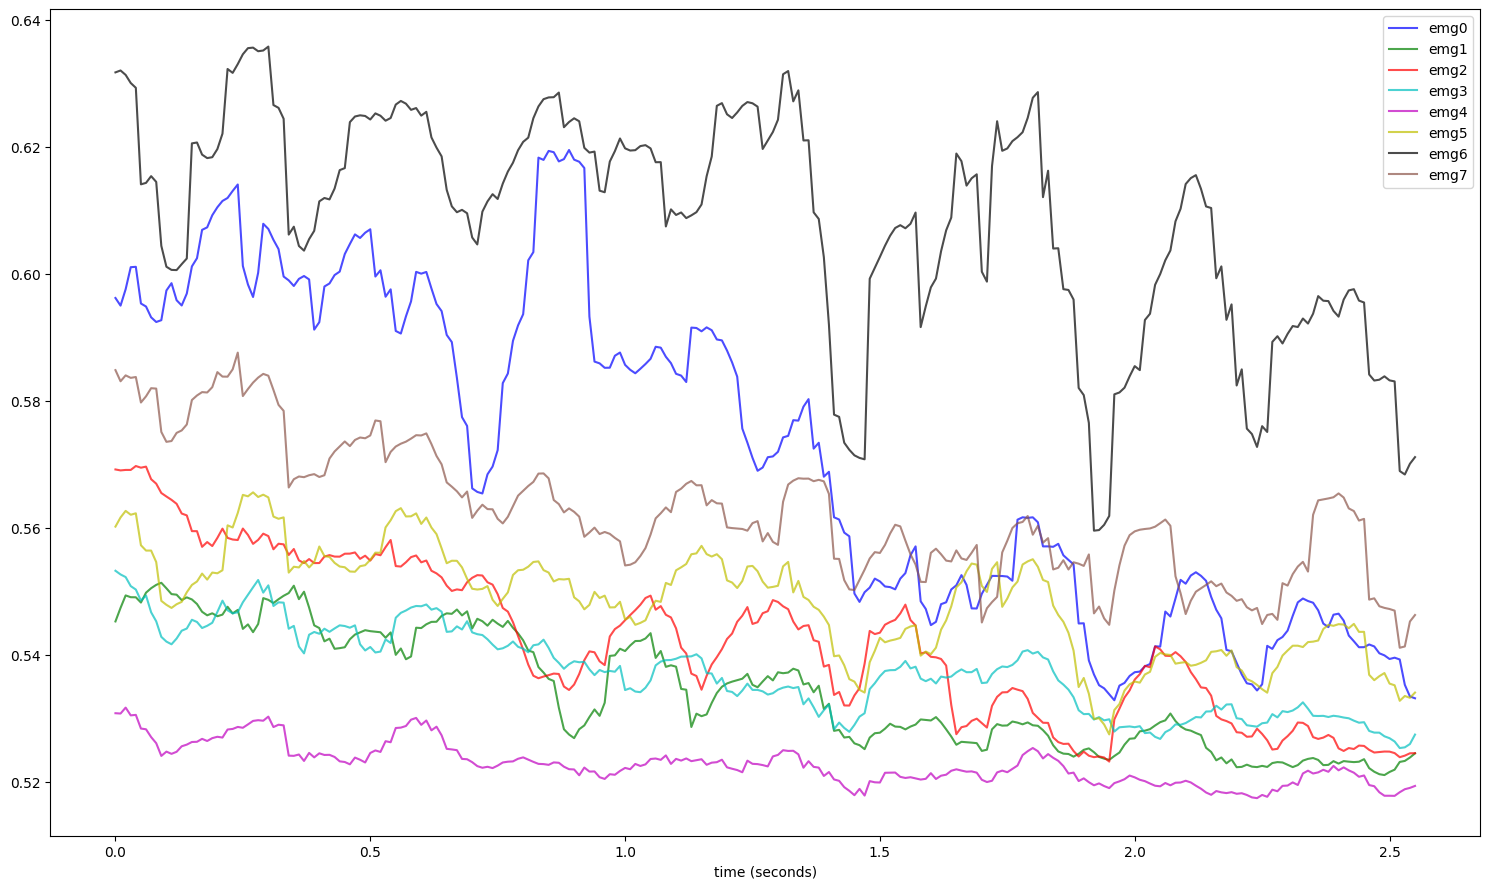

In [ ]:
plot_emg_chunks(model_output, nrows=1, ncols=1)

In [ ]:
best_loss, best_existing_seq, best_normalized_seq, best_id = find_similar_3(model_output, dataset)
print("best loss: ", best_loss)
print("best id: ", best_id)
print("best normalized: ")
plot_emg_chunks(best_normalized_seq, nrows=1, ncols=1)
print("best exist seq: ")
plot_emg_chunks(best_existing_seq, nrows=1, ncols=1)


In [ ]:
loader = torch.utils.data.DataLoader(dataset, shuffle=False, num_workers=0, batch_size=1)

for id, (exist_seq, y) in enumerate(loader): # exist_seq is of shape (1, 256, 8)
  exist_seq = exist_seq.squeeze()
  if id<10:
    plot_emg_chunks(exist_seq, nrows=1, ncols=1)


In [ ]:
!zip -r '/content/2Dunet-p8-111-close2-ep200.zip' '/content/2Dunet-p8-111-close2-ep200'

  adding: content/2Dunet-p8-111-close2-ep200/ (stored 0%)
  adding: content/2Dunet-p8-111-close2-ep200/diffusion_pytorch_model.bin (deflated 8%)
  adding: content/2Dunet-p8-111-close2-ep200/config.json (deflated 58%)


In [ ]:
from google.colab import files
files.download('/content/2Dunet-p8-111-close2-ep200.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>